In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

df = pd.read_csv("data/TOTAL_KSI.csv")

# PRE-PROCESSING

In [3]:
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df = df.dropna(subset=['DATE'])
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month
df['DAY'] = df['DATE'].dt.day
df['WEEKDAY'] = df['DATE'].dt.weekday

cols_to_drop = [
    "OBJECTID", "INDEX", "ACCNUM", "OFFSET",
    "x", "y", "HOOD_158", "NEIGHBOURHOOD_158", "HOOD_140", "NEIGHBOURHOOD_140", "DISTRICT",
    "FATAL_NO", "INVTYPE", 'INVAGE', "VEHTYPE",
    "STREET1", "STREET2", "INITDIR", "PEDTYPE", "PEDACT", "MANOEUVER", "DRIVACT", "CYCLISTYPE",
    "CYCACT", "DATE"
]

cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df.drop(columns=cols_to_drop, inplace=True)

df = df.dropna(subset=["ACCLASS"])

df.loc[df['ACCLASS'] == 'Property Damage O', 'INJURY'] = 'None'
df.loc[df['ACCLASS'] == 'Property Damage O', 'ACCLASS'] = 'Non-Fatal Injury'
df["TRAFFCTL"] = df["TRAFFCTL"].fillna("No_Control")


unknown_columns = [ 'PEDCOND', 'CYCCOND', 'DRIVCOND', "INJURY", "DIVISION", "TRAFFCTL"]
other_columns = ['ROAD_CLASS', 'ACCLOC', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'IMPACTYPE']
boolean_columns = ['PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY']

df[other_columns] = df[other_columns].fillna("Other")
df[unknown_columns] = df[unknown_columns].fillna("Unknown")
df[boolean_columns] = df[boolean_columns].fillna("No")


In [4]:
# COLUMNS LABELING
le_dict = {}
columns_to_encode = unknown_columns + other_columns + boolean_columns + ['ACCLASS']
for col in columns_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

In [5]:
df.dtypes

TIME               int64
ROAD_CLASS         int32
LATITUDE         float64
LONGITUDE        float64
ACCLOC             int32
TRAFFCTL           int32
VISIBILITY         int32
LIGHT              int32
RDSFCOND           int32
ACCLASS            int32
IMPACTYPE          int32
INJURY             int32
DRIVCOND           int32
PEDCOND            int32
CYCCOND            int32
PEDESTRIAN         int32
CYCLIST            int32
AUTOMOBILE         int32
MOTORCYCLE         int32
TRUCK              int32
TRSN_CITY_VEH      int32
EMERG_VEH          int32
PASSENGER          int32
SPEEDING           int32
AG_DRIV            int32
REDLIGHT           int32
ALCOHOL            int32
DISABILITY         int32
DIVISION           int32
YEAR               int32
MONTH              int32
DAY                int32
WEEKDAY            int32
dtype: object

In [6]:
pd.DataFrame(df)

,TIME,ROAD_CLASS,LATITUDE,LONGITUDE,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,...,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,DIVISION,YEAR,MONTH,DAY,WEEKDAY
0,236,5,43.699595,-79.318797,2,0,0,0,8,1,...,1,1,0,1,0,15,2006,1,1,6
1,236,5,43.699595,-79.318797,2,0,0,0,8,1,...,1,1,0,1,0,15,2006,1,1,6
2,236,5,43.699595,-79.318797,2,0,0,0,8,1,...,1,1,0,1,0,15,2006,1,1,6
3,236,5,43.699595,-79.318797,2,0,0,0,8,1,...,1,1,0,1,0,15,2006,1,1,6
4,236,5,43.699595,-79.318797,2,0,0,0,8,1,...,1,1,0,1,0,15,2006,1,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18952,2008,5,43.772151,-79.251460,2,9,2,1,8,1,...,0,1,0,0,0,11,2023,12,26,1
18953,1911,8,43.650847,-79.431903,2,0,5,0,8,0,...,0,0,0,0,0,3,2023,12,28,3
18954,1911,8,43.650847,-79.431903,2,0,5,0,8,0,...,0,0,0,0,0,3,2023,12,28,3
18955,1829,4,43.700789,-79.290279,2,0,5,0,8,1,...,0,0,0,0,0,9,2023,12,29,4


# RANDOM FOREST MODEL

In [7]:
target = df["ACCLASS"]
features = df.drop(columns=["ACCLASS"])

X = features
y = target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=37, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=1000, 
    random_state=37, 
    n_jobs=-1, 
    class_weight='balanced'
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=-1,
                       random_state=37)

# MODEL EVALUATION

In [8]:
y_pred = rf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81       667
           1       0.95      1.00      0.97      4072

    accuracy                           0.96      4739
   macro avg       0.97      0.84      0.89      4739
weighted avg       0.96      0.96      0.95      4739

Accuracy Score:
0.9556868537666174


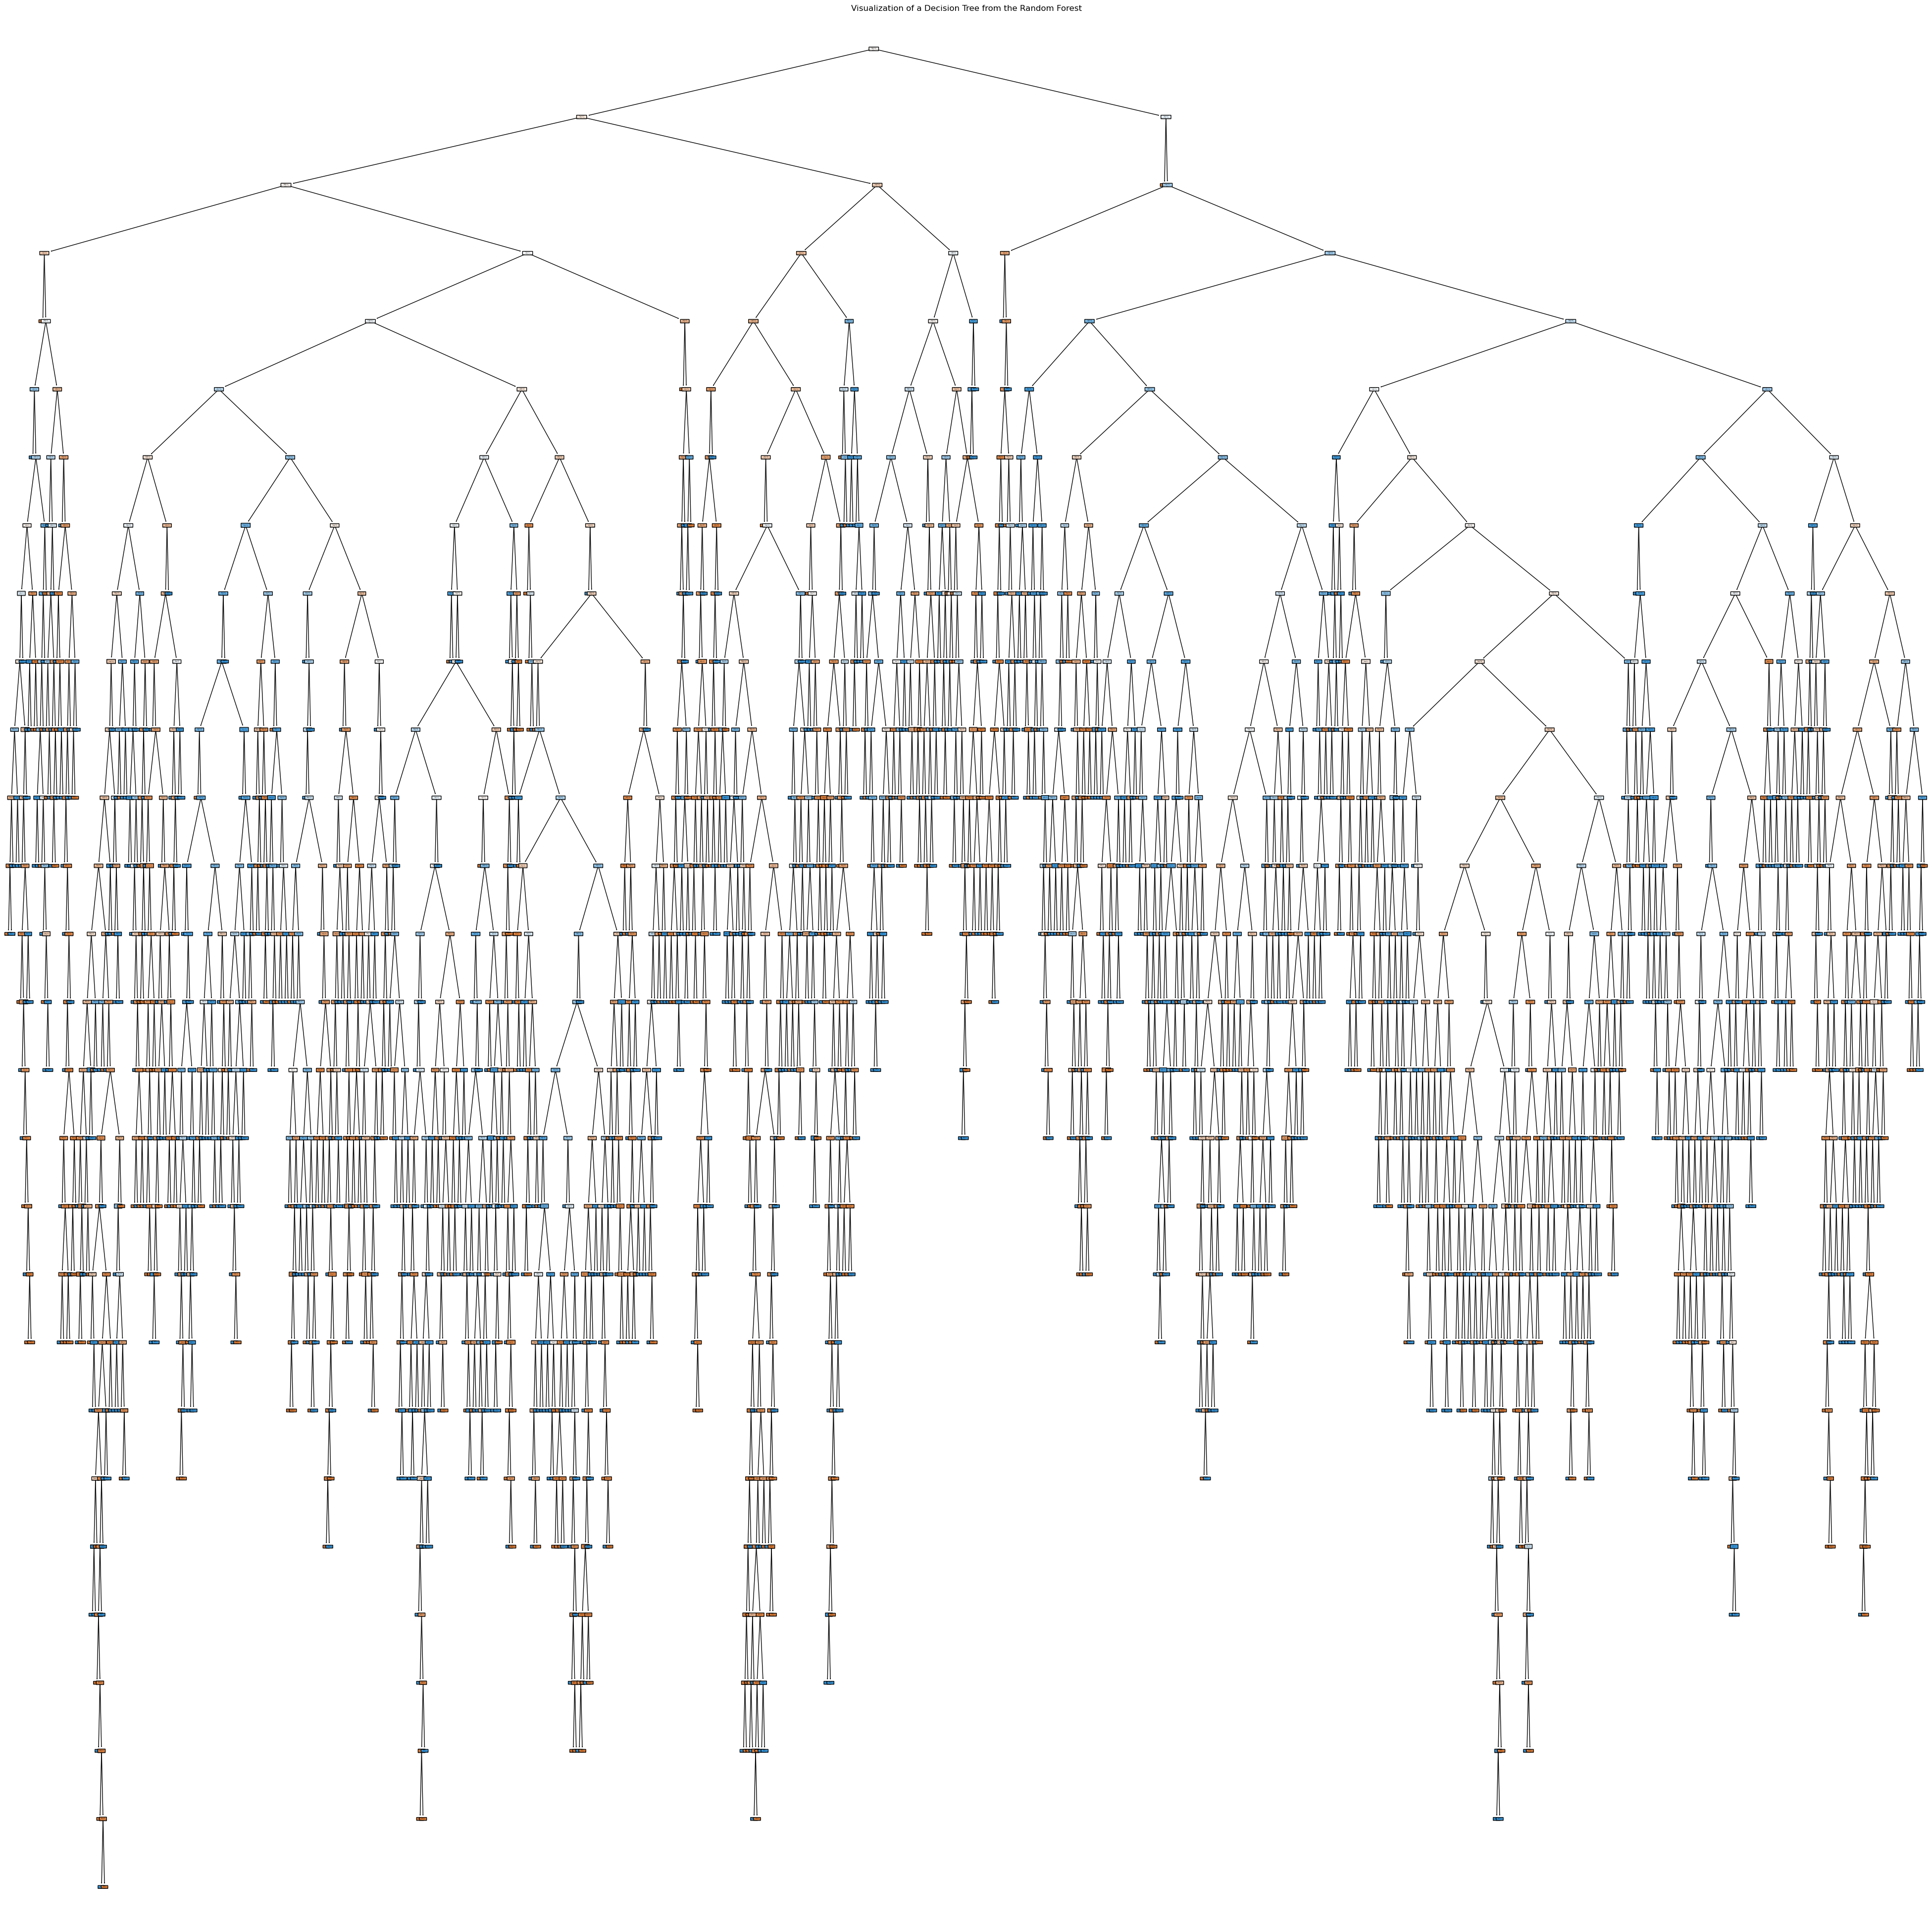

In [767]:
estimator = rf.estimators_[0]

plt.figure(figsize=(50, 50))
plot_tree(
    estimator,
    feature_names=X.columns,
    class_names=["0", "1"],
    filled=True,
    rounded=True,
    precision=2
)
plt.title("Visualization of a Decision Tree from the Random Forest")
plt.show()

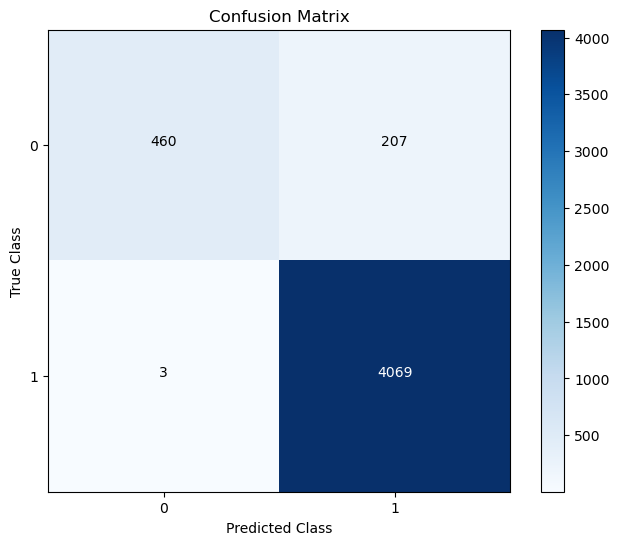

In [769]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = range(len(set(y_test)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
                 
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


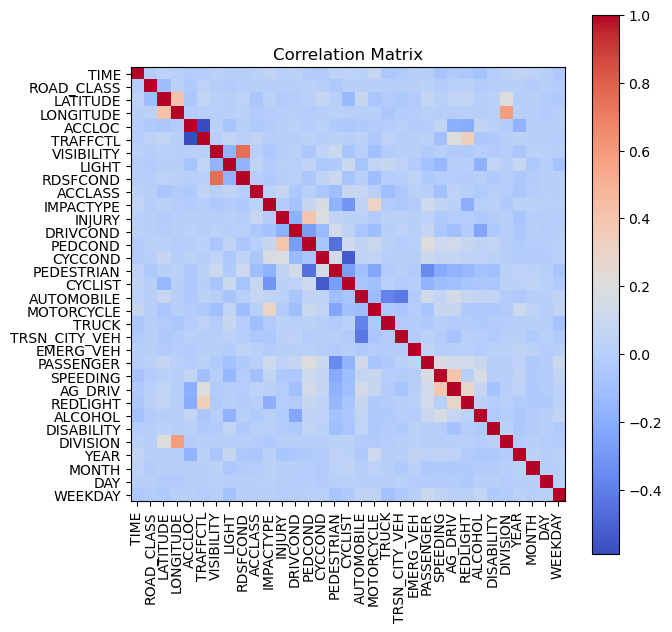

In [755]:
correlation_matrix = df.corr()

plt.figure(figsize=(7, 7))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Correlation Matrix")
plt.show()


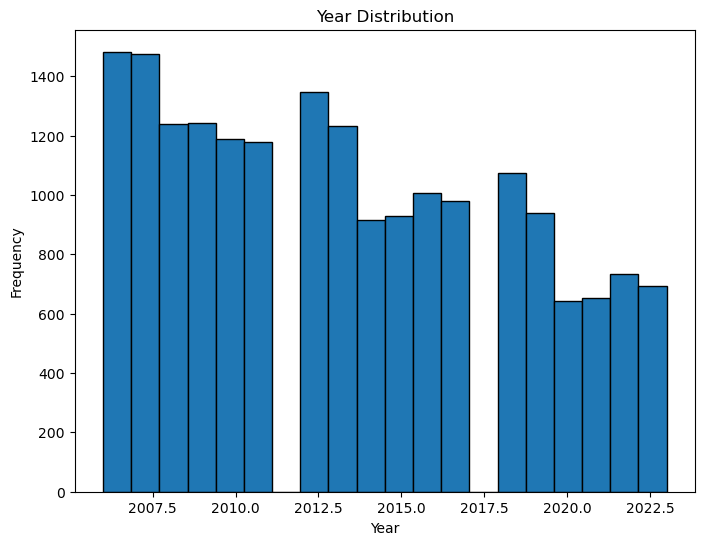

In [756]:
plt.figure(figsize=(8, 6))
plt.hist(df['YEAR'], bins=20, edgecolor='black')
plt.title("Year Distribution")
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.show()

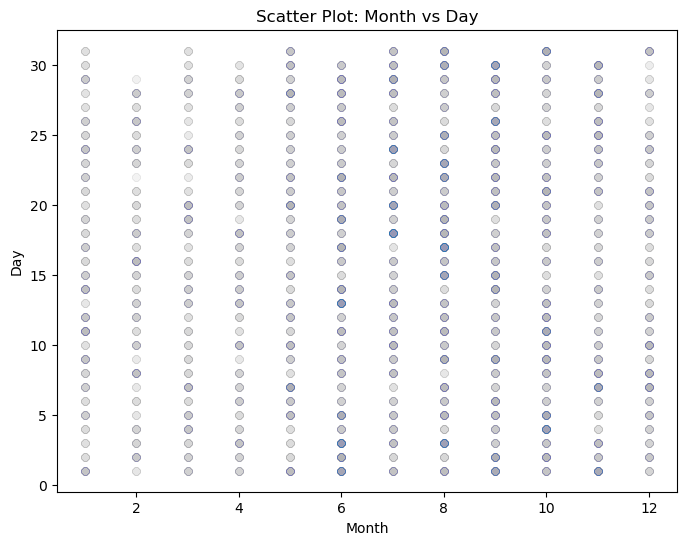

In [757]:
plt.figure(figsize=(8, 6))
plt.scatter(df['MONTH'], df['DAY'], alpha=0.005)
plt.title("Scatter Plot: Month vs Day")
plt.xlabel("Month")
plt.ylabel("Day")
plt.show()

In [15]:
# Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': df.feature_importances_
    }).sort_values('importance', ascending=False)


IndentationError: unexpected indent (1390392681.py, line 2)

In [12]:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features')
    plt.tight_layout()
    plt.savefig('insights/performance/feature_importance.png')
    plt.close()

ValueError: Could not interpret value `importance` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>